In [167]:
import json
import pandas as pd
import numpy as np
from scipy.optimize import linear_sum_assignment
from rouge_score import rouge_scorer
import Levenshtein
import matplotlib as plt

In [168]:
#load data for evaluation (loki generated atomic claims)
with open('translate/atomic_claims_FCGPT_claude_translated.json', 'r') as file:
    loki_translated = json.load(file)

with open('translate/translated.json', 'r') as file:
    dataset_translated = json.load(file)


### Data Loading & Preprocessing


In [169]:
# Extract GT claims (need handling lists, dicts, or strings)
gt_claims = []
for entry in dataset_translated:
    for item in entry.get('claims', []):
        if isinstance(item, list):
            # If the item is a list, add all string elements from it
            for claim in item:
                gt_claims.append(claim)
        elif isinstance(item, dict):
            gt_claims.append(item.get('claim', ''))
        elif isinstance(item, str):
            gt_claims.append(item)

# Extract LOKI-generated claims
loki_claims = []
for entry in loki_translated:
    for item in entry.get('claims', []):
        if isinstance(item, list):
            for claim in item:
                loki_claims.append(claim)
        elif isinstance(item, dict):
            loki_claims.append(item.get('claim', ''))
        elif isinstance(item, str):
            loki_claims.append(item)

print(f"Number of GT claims: {len(gt_claims)}")
print(f"Number of generated claims: {len(loki_claims)}")

Number of GT claims: 678
Number of generated claims: 837


##

### Computing Pairwise ROUGE Scores

In [170]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

In [171]:
def compute_rouge_f1(reference, candidate):
    scores = scorer.score(reference, candidate)

    # Here we use the F1 score for each ROUGE metric; you can adjust this if needed
    rouge1_f1 = scores['rouge1'].fmeasure
    rouge2_f1 = scores['rouge2'].fmeasure
    rougeL_f1 = scores['rougeL'].fmeasure

    # for simplicity, you might average these scores
    avg_f1 = np.mean([rouge1_f1, rouge2_f1, rougeL_f1])
    return avg_f1


# Create 2D array (cost or similarity matrix) of size (num_gt, num_generated)
num_gt = len(gt_claims)
num_gen = len(loki_claims)
similarity_matrix = np.zeros((num_gt, num_gen))

for i in range(num_gt):
    for j in range(num_gen):
        similarity_matrix[i, j] = compute_rouge_f1(gt_claims[i], loki_claims[j])


print("Similarity matrix (average ROUGE F1 scores):")
similarity_matrix


Similarity matrix (average ROUGE F1 scores):


array([[0.54444444, 0.20940171, 0.2952381 , ..., 0.        , 0.        ,
        0.        ],
       [0.29239766, 0.93856209, 0.26065163, ..., 0.        , 0.        ,
        0.        ],
       [0.39083821, 0.15931373, 0.55263158, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.06349206, ..., 0.06060606, 0.06060606,
        0.06060606],
       [0.        , 0.        , 0.07017544, ..., 0.06666667, 0.06666667,
        0.06666667],
       [0.        , 0.        , 0.07407407, ..., 0.07017544, 0.07017544,
        0.07017544]], shape=(678, 837))

### Align Claims Across Datasets

In [172]:
# Convert similarity matrix to cost matrix
cost_matrix = -similarity_matrix

# Get the optimal matching using the Hungarian algorithm (match each GT claim to one generated claim)
row_ind, col_ind = linear_sum_assignment(cost_matrix)

for r, c in zip(row_ind, col_ind):
    print(f"GT claim {r} matched with generated claim \" {c} \" with score {similarity_matrix[r, c]}")
    print(f"Best match in generated claims: \"{loki_claims[c]}\" with ROUGE F1 score: {similarity_matrix[r, c]}\n")

avg_matched_score = np.mean(similarity_matrix[row_ind, col_ind])

GT claim 0 matched with generated claim " 5 " with score 0.3634920634920635
Best match in generated claims: "William O. Douglas by byl nejstarší sloužící spravedlnosti v roce 1980." with ROUGE F1 score: 0.3634920634920635

GT claim 1 matched with generated claim " 1 " with score 0.9385620915032679
Best match in generated claims: "William O. Douglas se narodil 16. října 1898." with ROUGE F1 score: 0.9385620915032679

GT claim 2 matched with generated claim " 2 " with score 0.5526315789473685
Best match in generated claims: "William O. Douglas sloužil u Nejvyššího soudu z roku 1939." with ROUGE F1 score: 0.5526315789473685

GT claim 3 matched with generated claim " 4 " with score 0.7439613526570049
Best match in generated claims: "William O. Douglas byl stále naživu v roce 1980." with ROUGE F1 score: 0.7439613526570049

GT claim 4 matched with generated claim " 0 " with score 0.7015873015873016
Best match in generated claims: "William O. Douglas byl nejstarší soudce Nejvyššího soudu v ro

In [173]:
print(f"Average ROUGE F1 for matched pairs: {avg_matched_score}")
df = pd.DataFrame({'GT_Claim': gt_claims, 'LOKI_Claim': loki_claims[:len(gt_claims)]})
df

Average ROUGE F1 for matched pairs: 0.5574363882821687


,GT_Claim,LOKI_Claim
0,V roce 1980 byl nejstarším soudcem Nejvyššího soudu Spojených států soudce William O. Douglas.,William O. Douglas byl nejstarší soudce Nejvyššího soudu v roce 1980.
1,Soudce William O. Douglas se narodil 16. října 1898.,William O. Douglas se narodil 16. října 1898.
2,Soudce William O. Douglas sloužil u Nejvyššího soudu Spojených států od roku 1939 do jeho odchodu do důchodu v roce 1975.,William O. Douglas sloužil u Nejvyššího soudu z roku 1939.
3,V roce 1980 byl soudce William O. Douglas stále naživu.,William O. Douglas odešel z Nejvyššího soudu v roce 1975.
4,Soudce William O. Douglas byl nejstarším soudcem Nejvyššího soudu Spojených států v roce 1980.,William O. Douglas byl stále naživu v roce 1980.
...,...,...
673,Exciter je album z Depeche Mode,Kosmické baterie mají důležitý atribut života cyklu.
674,Hrát Angel je album z Depeche Mode,Kosmické baterie mají důležitý atribut společnosti.
675,Sounds of the Universe je album z Depeche Mode,Atributykosmických bateriích jsou realizovány díky pokročilým materiálům.
676,Delta Machine je album z Depeche Mode,Atributykosmických bateriích jsou realizovány díky efektivním designům.


In [174]:
pairs = []
for r, c in zip(row_ind, col_ind):
    pairs.append({
        'GT_Claim': gt_claims[r],
        'LOKI_Claim': loki_claims[c],
        'ROUGE_F1_Score': similarity_matrix[r, c]
    })

df_pairs = pd.DataFrame(pairs)
df_pairs

,GT_Claim,LOKI_Claim,ROUGE_F1_Score
0,V roce 1980 byl nejstarším soudcem Nejvyššího soudu Spojených států soudce William O. Douglas.,William O. Douglas by byl nejstarší sloužící spravedlnosti v roce 1980.,0.363492
1,Soudce William O. Douglas se narodil 16. října 1898.,William O. Douglas se narodil 16. října 1898.,0.938562
2,Soudce William O. Douglas sloužil u Nejvyššího soudu Spojených států od roku 1939 do jeho odchodu do důchodu v roce 1975.,William O. Douglas sloužil u Nejvyššího soudu z roku 1939.,0.552632
3,V roce 1980 byl soudce William O. Douglas stále naživu.,William O. Douglas byl stále naživu v roce 1980.,0.743961
4,Soudce William O. Douglas byl nejstarším soudcem Nejvyššího soudu Spojených států v roce 1980.,William O. Douglas byl nejstarší soudce Nejvyššího soudu v roce 1980.,0.701587
...,...,...,...
673,Exciter je album z Depeche Mode,Exciter je album Depeche Mode.,0.828283
674,Hrát Angel je album z Depeche Mode,Hrát Angel je album Depeche Mode.,0.878632
675,Sounds of the Universe je album z Depeche Mode,Sounds of the Universe je album Depeche Mode.,0.894118
676,Delta Machine je album z Depeche Mode,Delta Machine je album Depeche Mode.,0.857809


### Conclusion

In [175]:
# Assuming row_ind and col_ind come from the Hungarian algorithm matching
avg_matched_score = np.mean(similarity_matrix[row_ind, col_ind])
print(f"Overall Average ROUGE F1 for matched pairs: {avg_matched_score:.3f}")

Overall Average ROUGE F1 for matched pairs: 0.557


In [176]:
# Define a threshold for a "good" match, e.g., 0.7
threshold = 0.7

# For each GT claim, check if its best matched score is above the threshold
matched_scores = similarity_matrix[row_ind, col_ind]
num_good_matches = np.sum(matched_scores >= threshold)
claim_recall = num_good_matches / num_gt
print(f"N-grams ROUGE Metric: Claim Recall (fraction of GT claims with a match >= {threshold}): {claim_recall:.2%}")

# For precision, we consider the number of unique generated claims that are "good matches"
good_generated = set(c for r, c in zip(row_ind, col_ind) if similarity_matrix[r, c] >= threshold)
claim_precision = len(good_generated) / num_gen
print(f"N-grams ROUGE Metric: Claim Precision (fraction of generated claims that are good matches): {claim_precision:.2%}")

N-grams ROUGE Metric: Claim Recall (fraction of GT claims with a match >= 0.7): 29.35%
N-grams ROUGE Metric: Claim Precision (fraction of generated claims that are good matches): 23.78%


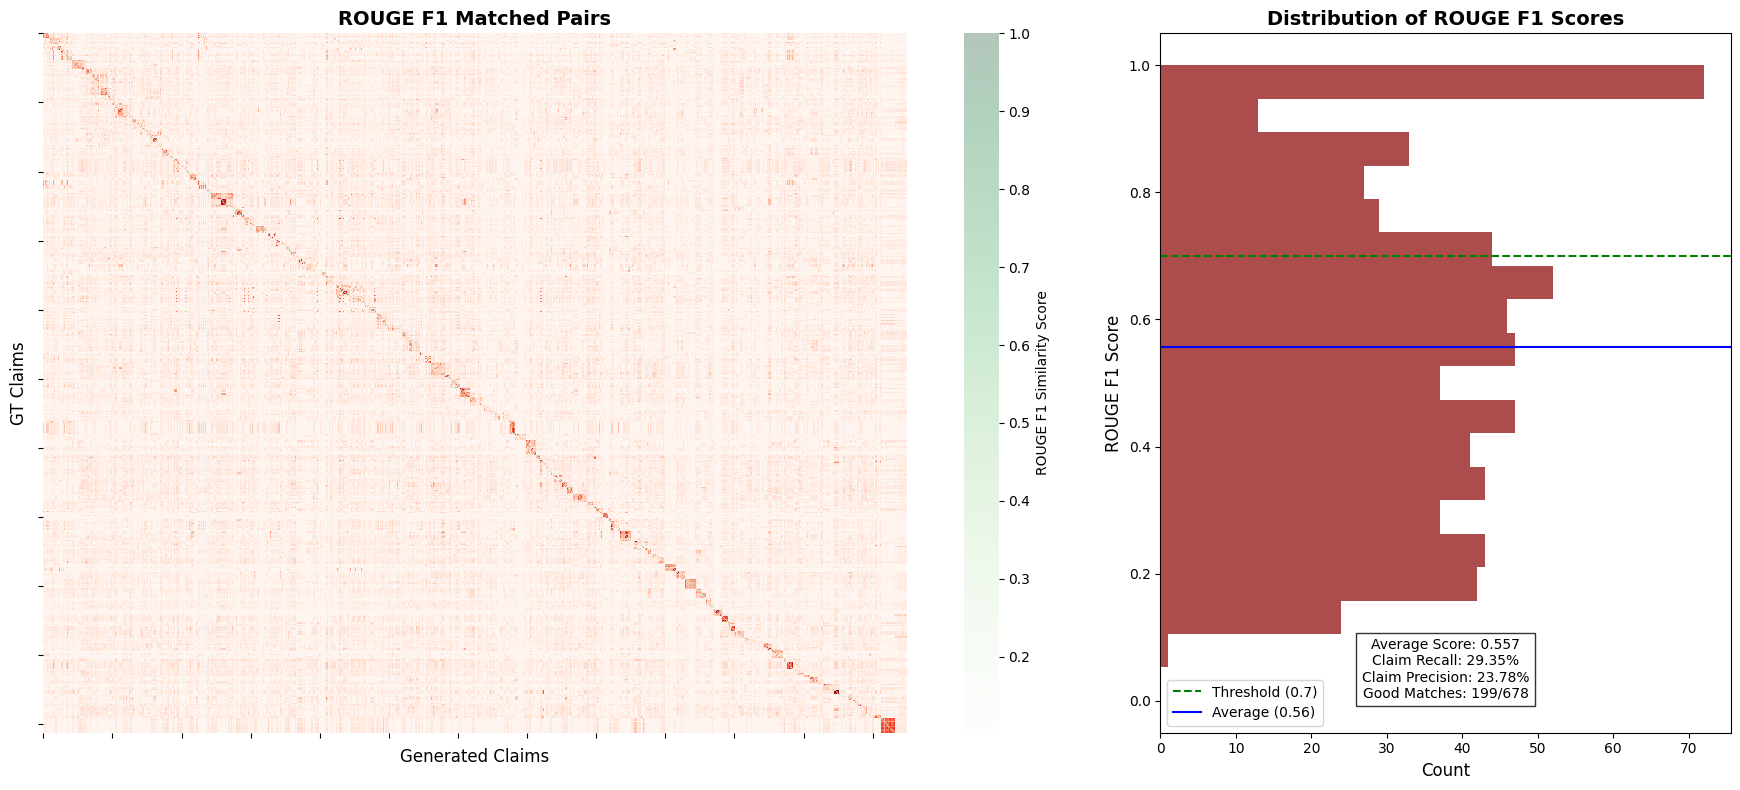

In [177]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a figure with two subplots: heatmap and score distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), gridspec_kw={'width_ratios': [2, 1]})

# 1. Enhanced heatmap with matched pairs highlighted
# Create a mask to highlight only the matched pairs
mask = np.ones_like(similarity_matrix, dtype=bool)
for r, c in zip(row_ind, col_ind):
    mask[r, c] = False

# Plot the similarity matrix with the mask
sns.heatmap(
    similarity_matrix,
    cmap='Greens',
    mask=mask,
    cbar_kws={'label': 'ROUGE F1 Similarity Score'},
    ax=ax1,
    square=True,
    alpha=0.3  # Make unmatched pairs transparent
)

# Add the matched pairs with a different colormap
sns.heatmap(
    similarity_matrix,
    cmap='Reds',
    mask=~mask,  # Inverted mask to show only matched pairs
    cbar=False,
    ax=ax1,
    square=True
)

# Improve readability
ax1.set_title('ROUGE F1 Matched Pairs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Generated Claims', fontsize=12)
ax1.set_ylabel('GT Claims', fontsize=12)

# Reduce tick density for large matrices
if similarity_matrix.shape[0] > 20 or similarity_matrix.shape[1] > 20:
    step = max(1, min(similarity_matrix.shape) // 10)
    ax1.set_xticks(np.arange(0, similarity_matrix.shape[1], step))
    ax1.set_yticks(np.arange(0, similarity_matrix.shape[0], step))

# 2. Distribution of matched scores
matched_scores = similarity_matrix[row_ind, col_ind]
bins = np.linspace(0, 1, 20)
ax2.hist(matched_scores, bins=bins, orientation='horizontal', color='darkred', alpha=0.7)
ax2.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold ({threshold})')
ax2.axhline(y=avg_matched_score, color='blue', linestyle='-', label=f'Average ({avg_matched_score:.2f})')
ax2.set_title('Distribution of ROUGE F1 Scores', fontsize=14, fontweight='bold')
ax2.set_xlabel('Count', fontsize=12)
ax2.set_ylabel('ROUGE F1 Score', fontsize=12)
ax2.legend()

# Add text with metrics
metrics_text = (
    f"Average Score: {avg_matched_score:.3f}\n"
    f"Claim Recall: {claim_recall:.2%}\n"
    f"Claim Precision: {claim_precision:.2%}\n"
    f"Good Matches: {num_good_matches}/{num_gt}"
)
ax2.text(0.5, 0.05, metrics_text, transform=ax2.transAxes,
         bbox=dict(facecolor='white', alpha=0.8), ha='center')

plt.tight_layout()
plt.show()

## Edit distance metrics